<a href="https://colab.research.google.com/github/lisaong/diec/blob/master/edge_time_series_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Edge Device Model Deployment

In this notebook, we will train a deep learning model and deploy it to the edge.

1. Train model using Keras (with Tensorflow backend)
2. Convert to compressed floating point version using Tensorflow Lite
3. Deploy on Raspberry Pi

We will use this dataset, which is gathered from a smart factory in Germany: https://www.kaggle.com/inIT-OWL/versatileproductionsystem



In [0]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, Flatten
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Dataset

Load the dataset from our github repository.

In [0]:
!curl https://raw.githubusercontent.com/lisaong/diec/master/data/versatileproductionsystem.zip --output data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  397k  100  397k    0     0  1044k      0 --:--:-- --:--:-- --:--:-- 1041k


In [0]:
!unzip -o data.zip

Archive:  data.zip
  inflating: Filling_CapScrewer.module.csv  
  inflating: Filling_ALL.module.csv  
  inflating: Dosingmodule.csv        
  inflating: Filling_CornPortioning.module.csv  
  inflating: Filling_Pump.module.csv  
  inflating: Deliverymodule.csv      
  inflating: Filling_CapGrabber.module.csv  
  inflating: Production.csv          
  inflating: Storagemodule.csv       


In [0]:
# read one of the data files
df = pd.read_csv('./Filling_ALL.module.csv', index_col=0)
df.head()

,I_BottleAtAirpipe,I_BottleClampClose,I_BottleClampOpen,I_BottleGateClosed,I_BottleReserveGateClosed,I_BottlesAvailable,I_BottleSlot1,I_BottleSlot2_H2O,I_BottleSlot3_Corn,I_BottleSlot5_CapOn,I_BottleSlot6_CapScrewer,I_BottleSlot8_Output,I_BottlesReserveAvailable,I_BottleStorageFull,I_CapGrabberDown,I_CapGrabberUp,I_CapOnConveyor,I_CapScrewer_Down,I_CapScrewer_Up,I_CapScrewerClosePos,I_CapScrewerGrabClosed,I_CapScrewerOpenPos,I_CornTankFull,I_LinAxisCapInGrabber,I_LinAxisDown,I_LinAxisEmptyGrabber,I_LinAxisUp,I_NoCapOnConveyor,I_Portioning,I_Pump_Down,I_Pump_Up,I_RotaryTablePosReached,I_UltrasonicCorn,I_UltrasonicCorn_Distance,I_UltrasonicH2O,I_UltrasonicH2O_Distance,I_WaterTankMinFull,I_WaterTankNotFull,O_ActivateAirpipe,O_BottleClampClose,...,O_CloseCap,O_ConveyorCapsEnable,O_ConveyorCapsForward,O_ConveyorModuleIn,O_ConveyorModuleOut,O_GateBottleClose,O_GateReserveClose,O_LinAxisUpDown,O_PortionerForward,O_PortionerReverse,O_PortionerSlow,O_PumpUpDown,O_RotaryTable,O_ValvePumpCloseOpen,PendingOrder,Portions,PumpStrokes,Rotating,SlowPortioning,State,BottlesAvailable,BottleSlot1,BottleSlot2_H2O,BottleSlot3_Corn,BottleSlot5_CapOn,BottleSlot6_CapCloser,BottleSlot8_ModuleOut,BottlesNotUsed,UltraSonic_Corn.DistanceM,UltraSonic_H2O.DistanceM,BottlesAvailable.AnalogValue.EURangeViolation,BottleSlot1.AnalogValue.EURangeViolation,BottleSlot2_H2O.AnalogValue.EURangeViolation,BottleSlot3_Corn.AnalogValue.EURangeViolation,BottleSlot5_CapOn.AnalogValue.EURangeViolation,BottleSlot6_CapCloser.AnalogValue.EURangeViolation,BottleSlot8_ModuleOut.AnalogValue.EURangeViolation,BottlesNotUsed.AnalogValue.EURangeViolation,UltraSonic_Corn.DistanceM.EURangeViolation,UltraSonic_H2O.DistanceM.EURangeViolation
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1529500027127,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,1,1483,0,2500,1,1,0,0,...,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,4,3,0,0,0,2168,1196,1246,1054,1605,1246,1257,1864,1483,2500,0,0,0,0,0,0,0,0,0,0
1529500027227,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,1,1484,0,2500,1,1,0,0,...,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,4,3,0,0,0,2167,1196,1247,1053,1605,1246,1257,1864,1484,2500,0,0,0,0,0,0,0,0,0,0
1529500027327,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,1,1480,0,2500,1,1,0,0,...,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,4,3,0,0,0,2168,1196,1247,1054,1605,1246,1257,1864,1480,2500,0,0,0,0,0,0,0,0,0,0
1529500027428,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,1,1480,0,2500,1,1,0,0,...,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,4,3,0,0,0,2168,1196,1246,1053,1605,1246,1257,1864,1480,2500,0,0,0,0,0,0,0,0,0,0
1529500027528,0,0,1,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,1,0,1,1,1484,0,2500,1,1,0,0,...,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,4,3,0,0,0,2167,1196,1247,1053,1605,1246,1257,1863,1484,2500,0,0,0,0,0,0,0,0,0,0


## Task Definition

A common factory monitoring scenario is to predict a target based on past history.

For the purposes of this workshop, let's try to predict the value of 'I_BottlesReserveAvailable', using last 10 values of each feature.

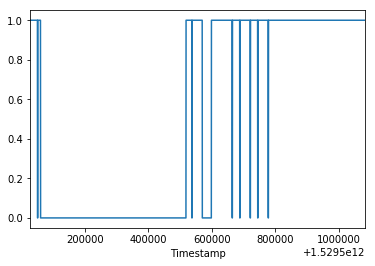

In [0]:
# Target
target = 'I_BottlesReserveAvailable'

df[target].plot()

In [0]:
# check for balanced classes
df[target].value_counts()

1    5603
0    4926
Name: I_BottlesReserveAvailable, dtype: int64

In [0]:
# drop some columns that the target is derived from (otherwise we are cheating)
df.drop(['BottlesAvailable', 'BottlesNotUsed', 'I_BottleStorageFull'], axis=1, inplace=True)
df.columns

Index(['I_BottleAtAirpipe', 'I_BottleClampClose', 'I_BottleClampOpen',
       'I_BottleGateClosed', 'I_BottleReserveGateClosed', 'I_BottlesAvailable',
       'I_BottleSlot1', 'I_BottleSlot2_H2O', 'I_BottleSlot3_Corn',
       'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottleSlot8_Output', 'I_BottlesReserveAvailable', 'I_CapGrabberDown',
       'I_CapGrabberUp', 'I_CapOnConveyor', 'I_CapScrewer_Down',
       'I_CapScrewer_Up', 'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed',
       'I_CapScrewerOpenPos', 'I_CornTankFull', 'I_LinAxisCapInGrabber',
       'I_LinAxisDown', 'I_LinAxisEmptyGrabber', 'I_LinAxisUp',
       'I_NoCapOnConveyor', 'I_Portioning', 'I_Pump_Down', 'I_Pump_Up',
       'I_RotaryTablePosReached', 'I_UltrasonicCorn',
       'I_UltrasonicCorn_Distance', 'I_UltrasonicH2O',
       'I_UltrasonicH2O_Distance', 'I_WaterTankMinFull', 'I_WaterTankNotFull',
       'O_ActivateAirpipe', 'O_BottleClampClose', 'O_CapGrabberOpenClose',
       'O_CapGrabberUpDown', 'O

## Reserve for testing

Reserve the some values for testing on the Raspberry Pi.


In [0]:
test_size = 100

df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]

df_train.shape, df_test.shape

((10429, 81), (100, 81))

In [0]:
# save input numpy arrays for later use
pickle.dump(df_train.loc[:, df_train.columns != target].values,
            open('./X_train.pkl', 'wb'))

pickle.dump(df_test.loc[:, df_test.columns != target].values,
            open('./X_test.pkl', 'wb'))

## Feature Selection

First, some basic feature selection: Filter out columns that don't change very much (low variance). 

In [0]:
# Candidate features

candidates = df_train.columns[df_train.columns != target]
candidates

Index(['I_BottleAtAirpipe', 'I_BottleClampClose', 'I_BottleClampOpen',
       'I_BottleGateClosed', 'I_BottleReserveGateClosed', 'I_BottlesAvailable',
       'I_BottleSlot1', 'I_BottleSlot2_H2O', 'I_BottleSlot3_Corn',
       'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_BottleSlot8_Output', 'I_CapGrabberDown', 'I_CapGrabberUp',
       'I_CapOnConveyor', 'I_CapScrewer_Down', 'I_CapScrewer_Up',
       'I_CapScrewerClosePos', 'I_CapScrewerGrabClosed', 'I_CapScrewerOpenPos',
       'I_CornTankFull', 'I_LinAxisCapInGrabber', 'I_LinAxisDown',
       'I_LinAxisEmptyGrabber', 'I_LinAxisUp', 'I_NoCapOnConveyor',
       'I_Portioning', 'I_Pump_Down', 'I_Pump_Up', 'I_RotaryTablePosReached',
       'I_UltrasonicCorn', 'I_UltrasonicCorn_Distance', 'I_UltrasonicH2O',
       'I_UltrasonicH2O_Distance', 'I_WaterTankMinFull', 'I_WaterTankNotFull',
       'O_ActivateAirpipe', 'O_BottleClampClose', 'O_CapGrabberOpenClose',
       'O_CapGrabberUpDown', 'O_CapScrewDown', 'O_CapScrewerGrabber

In [0]:
# Apply variance threshold of 0.1
vt = VarianceThreshold(threshold=0.1)
vt.fit(df_train[candidates])

# filtered out features
features = candidates[vt.get_support()]
features

Index(['I_BottleClampClose', 'I_BottleClampOpen', 'I_BottleSlot2_H2O',
       'I_BottleSlot3_Corn', 'I_BottleSlot5_CapOn', 'I_BottleSlot6_CapScrewer',
       'I_CapGrabberUp', 'I_CapScrewer_Up', 'I_CapScrewerOpenPos',
       'I_LinAxisCapInGrabber', 'I_LinAxisDown', 'I_LinAxisEmptyGrabber',
       'I_Pump_Down', 'I_RotaryTablePosReached', 'I_UltrasonicCorn',
       'I_UltrasonicCorn_Distance', 'I_UltrasonicH2O_Distance',
       'O_BottleClampClose', 'O_CapGrabberOpenClose', 'O_CapGrabberUpDown',
       'O_CapScrewDown', 'O_CloseCap', 'O_ConveyorCapsForward',
       'O_LinAxisUpDown', 'O_RotaryTable', 'O_ValvePumpCloseOpen',
       'PendingOrder', 'Rotating', 'State', 'BottleSlot1', 'BottleSlot2_H2O',
       'BottleSlot3_Corn', 'BottleSlot5_CapOn', 'BottleSlot6_CapCloser',
       'BottleSlot8_ModuleOut', 'UltraSonic_Corn.DistanceM',
       'UltraSonic_H2O.DistanceM'],
      dtype='object')

## Scaling

Next, scale the features so that we can speed up training.

In [0]:
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
feature_values = feature_scaler.fit_transform(df_train[features])
feature_values

array([[-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.94641148,  1.        ],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.94449761,  1.        ],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.95215311,  1.        ],
       ...,
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.99808612, -0.53684211],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.99808612, -0.53684211],
       [-1.        ,  1.        , -1.        , ..., -0.99369085,
        -0.99808612, -0.53684211]])

## Time Series Windowing

Next, convert the time series so that each entry contains a series of timesteps.

Before: rows, features

After: rows, timesteps, features

Note that some rows will be removed because we are taking a window of values.

In [0]:
timesteps = 10

print(feature_values.shape) # (rows, features)

rolling_indexes = [(range(i, i+timesteps))
                   for i in range(feature_values.shape[0]-timesteps)]

X_sequence = np.take(feature_values, rolling_indexes, axis=0)
X_sequence.shape # (rows, timesteps, features)

(10429, 37)


(10419, 10, 37)

In [0]:
# shift y down by 1 value so that we are predicting the future
# make sure y is the same length as X_sequence

print(df[target].shape)
y = df[target][1:X_sequence.shape[0]+1].values
y.shape

(10529,)


(10419,)

In [0]:
X_sequence[0]

array([[-1.        ,  1.        , -1.        , -1.        , -1.        ,
        -1.        ,  1.        ,  1.        ,  1.        , -1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        -0.94641148,  1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ,  1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.99896534,
        -1.        , -0.99788023, -0.99847095, -0.9986532 , -0.99369085,
        -0.94641148,  1.        ],
       [-1.        ,  1.        , -1.        , -1.        , -1.        ,
        -1.        ,  1.        ,  1.        ,  1.        , -1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        -0.94449761,  1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ,  1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.99896534,
        -0.99890

In [0]:
y[0]

1

## Train model

We will train a very simple 1D convolutional model to try to predict y from X_sequence. 

To recap:

- X_sequence (rows, timesteps, features): each scaled feature at [t-9] ... [t]
- y (rows): target[t+1]

The convolutional 1D layer will look at windows of timesteps, one feature at a time. Here's a more detailed reference on it for time series data: https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/


Note: we can also train an LSTM model, but currently Tensorflow Lite with Keras does not support it nicely (yet): https://github.com/tensorflow/tensorflow/issues/30864

In [0]:
# create training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_sequence, y, test_size=0.1,
                                                  stratify=y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((9377, 10, 37), (1042, 10, 37), (9377,), (1042,))

In [0]:
model = Sequential()

# input_shape=(timesteps, features)
model.add(Conv1D(64, kernel_size=3,
                 input_shape=(X_train.shape[1], X_train.shape[2]),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 64)             7168      
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 40,065
Trainable params: 40,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
mc = ModelCheckpoint('./cnn.h5', save_best_only=True)

In [0]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val), callbacks=[mc])


Train on 9377 samples, validate on 1042 samples
Epoch 1/20
9377/9377 [==============================] - 3s 349us/step - loss: 0.2201 - acc: 0.9057 - val_loss: 0.1487 - val_acc: 0.9309
Epoch 2/20
9377/9377 [==============================] - 2s 171us/step - loss: 0.1236 - acc: 0.9442 - val_loss: 0.1267 - val_acc: 0.9511
Epoch 3/20
9377/9377 [==============================] - 2s 171us/step - loss: 0.1048 - acc: 0.9533 - val_loss: 0.1231 - val_acc: 0.9463
Epoch 4/20
9377/9377 [==============================] - 2s 174us/step - loss: 0.0897 - acc: 0.9573 - val_loss: 0.0700 - val_acc: 0.9798
Epoch 5/20
9377/9377 [==============================] - 2s 172us/step - loss: 0.0822 - acc: 0.9606 - val_loss: 0.0732 - val_acc: 0.9674
Epoch 6/20
9377/9377 [==============================] - 2s 176us/step - loss: 0.0758 - acc: 0.9644 - val_loss: 0.0868 - val_acc: 0.9626
Epoch 7/20
9377/9377 [==============================] - 2s 172us/step - loss: 0.0704 - acc: 0.9694 - val_loss: 0.0645 - val_acc: 0.9770

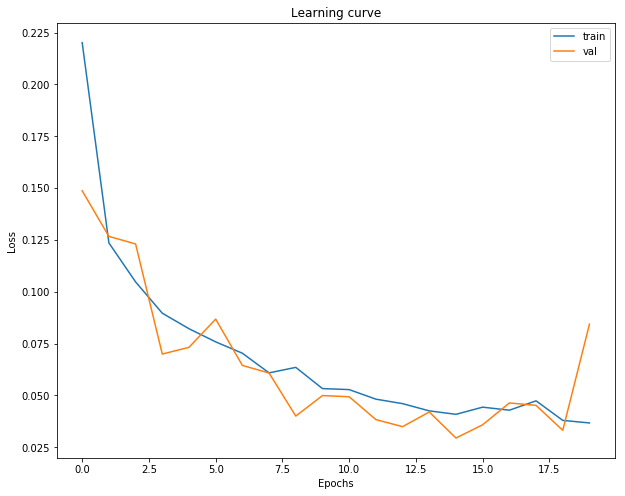

In [0]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.legend()
ax.set_title('Learning curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

### Predictions

We'll test the model by getting predictions for our test data.

The steps followed here will be repeated on the Raspberry Pi, so we want to make sure these are repeatable.

In [0]:
df_test_X = df_test.loc[:, df_test.columns != target]
df_test_y = df_test[[target]]

df_test_X.shape, df_test_y.shape

((100, 80), (100, 1))

In [0]:
# select features
test_X = vt.transform(df_test_X)

# scale
test_X_scaled = feature_scaler.transform(test_X)

# create windowed
rolling_indexes = [(range(i, i+timesteps))
                   for i in range(test_X_scaled.shape[0]-timesteps)]

test_X_sequence = np.take(test_X_scaled, rolling_indexes, axis=0)

print(test_X_sequence.shape) # (rows, timesteps, features)

(90, 10, 37)


In [0]:
# shift y down by 1 value so that we are predicting the future
# make sure y is the same length as test_X_sequence

test_y = df_test_y[1:test_X_sequence.shape[0]+1] 
print(test_y.shape)

(90, 1)


In [0]:
# predict by loading the checkpointed model with the lowest validation loss
best_model = load_model('./cnn.h5')
pred = best_model.predict_classes(test_X_sequence)

In [0]:
# score
print(classification_report(test_y, pred))
print(confusion_matrix(test_y, pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        90

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

[[90]]


In [0]:
# try to predict some class 0 values using validation set

pred_val = model.predict_classes(X_val)

print(classification_report(y_val, pred_val))
print(confusion_matrix(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       493
           1       0.96      0.98      0.97       549

    accuracy                           0.97      1042
   macro avg       0.97      0.97      0.97      1042
weighted avg       0.97      0.97      0.97      1042

[[473  20]
 [ 11 538]]


## Deployment

1. Save pre-processors
2. Convert to Tensorflow Lite: https://www.tensorflow.org/lite/convert#from_model_training_to_device_deployment

In [0]:
# Save preprocessors, create a dictionary so that everything in 1 place

preprocessors = {
    'variance_threshold' : vt,
    'feature_scaler' : feature_scaler   
}

pickle.dump(preprocessors, open('./preprocessors.pkl', 'wb'))

In [0]:
# Convert to Tensorflow lite
# https://www.tensorflow.org/lite/convert#from_model_training_to_device_deployment

import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model_file('./cnn.h5')

# https://www.tensorflow.org/api_docs/python/tf/lite/Optimize
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY] 

tflite_model = converter.convert()
with open('./cnn.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.


### Testing TensorFlow Lite Inference

https://www.tensorflow.org/lite/guide/inference#running_a_model

Before running inference on a Raspberry Pi, it is easier to write code and test out the inference on the desktop machine first.

The code below is a consolidated version of earlier code to process data.

In [0]:
# This is the code we will run on the Raspberry Pi
import pickle
import numpy as np
import tensorflow as tf

def load_test_data(data_filename, preprocessors_filename):
  timesteps = 10

  # Load test data and process it
  test_array = pickle.load(open(data_filename, 'rb'))

  preprocessors = pickle.load(open(preprocessors_filename, 'rb'))
  vt = preprocessors['variance_threshold']
  feature_scaler = preprocessors['feature_scaler']

  # select features
  test_X = vt.transform(test_array)

  # scale
  test_X_scaled = feature_scaler.transform(test_X)

  # create windowed
  rolling_indexes = [(range(i, i+timesteps))
                     for i in range(test_X_scaled.shape[0]-timesteps)]

  test_X_sequence = np.take(test_X_scaled, rolling_indexes, axis=0)
  print(test_X_sequence.shape) # (rows, timesteps, features)
    
  return test_X_sequence

In [0]:
X_test = load_test_data('./X_test.pkl', './preprocessors.pkl')

(90, 10, 37)


In [0]:
def predict(model_path, test_data):
  # Load TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # Test model on input data.
  input_shape = input_details[0]['shape']

  # Loop through each row of test_data and perform inference
  for i in range(test_data.shape[0]):

    # add batch dimension
    input_data = np.expand_dims(test_data[i], axis=0).astype('float32')

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print(output_data)

In [0]:
X_test = load_test_data('./X_test.pkl', './preprocessors.pkl')

predict('./cnn.tflite', X_test)

(90, 10, 37)
[[0.9999999]]
[[0.99999964]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.9999989]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999917]]
[[0.99999917]]
[[0.99999917]]
[[0.99999917]]
[[0.99999917]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.9999989]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[0.99999905]]
[[

In [0]:
X_train = load_test_data('./X_train.pkl', './preprocessors.pkl')

predict('./cnn.tflite', X_train)

(10419, 10, 37)
[[0.99784684]]
[[0.997844]]
[[0.99784243]]
[[0.9978517]]
[[0.9978515]]
[[0.99784696]]
[[0.99784505]]
[[0.9978516]]
[[0.99785894]]
[[0.9978503]]
[[0.99786466]]
[[0.9978536]]
[[0.9974898]]
[[0.99730057]]
[[0.99746275]]
[[0.9974909]]
[[0.9976914]]
[[0.9980469]]
[[0.9983444]]
[[0.9981371]]
[[0.99864143]]
[[0.99806803]]
[[0.9978483]]
[[0.9978477]]
[[0.9978453]]
[[0.9978466]]
[[0.9978531]]
[[0.99785644]]
[[0.9978522]]
[[0.99786156]]
[[0.9978503]]
[[0.997851]]
[[0.99784684]]
[[0.997849]]
[[0.9978421]]
[[0.9978399]]
[[0.99785775]]
[[0.9978514]]
[[0.9978416]]
[[0.99783224]]
[[0.9978472]]
[[0.99785477]]
[[0.9978497]]
[[0.99784243]]
[[0.9978517]]
[[0.9978543]]
[[0.9978428]]
[[0.99784625]]
[[0.9978399]]
[[0.9978382]]
[[0.99783945]]
[[0.99784076]]
[[0.9978389]]
[[0.9978362]]
[[0.9978389]]
[[0.9978515]]
[[0.99784625]]
[[0.9978415]]
[[0.99784756]]
[[0.99784446]]
[[0.99785244]]
[[0.99784017]]
[[0.99783945]]
[[0.9978398]]
[[0.99783915]]
[[0.99784875]]
[[0.9978405]]
[[0.99784935]]
[[0.99